In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import statsmodels.api as st

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

In [2]:
np.random.seed(72)

### Import the Data

In [3]:
start_date_f = "2021-10-01"
start_date_p = "2021-10-02"
end_date = "2023-11-08"

# Create a boolean mask based on the date range
dates = lambda df : (df.index >= start_date_f) & (df.index <= end_date)
dates_p = lambda df : (df.index >= start_date_p) & (df.index <= end_date)

In [4]:
# Target variable (stationary)
passengers_df = pd.read_csv("passengers_stationary.csv").set_index("datetime")
passengers_df.index = pd.to_datetime(passengers_df.index, format = "ISO8601")

passengers = passengers_df[["total"]].dropna()

# Features
features = pd.read_csv("features.csv").set_index("Unnamed: 0")
features.rename_axis('datetime', inplace = True)
features.index = pd.to_datetime(features.index, format = "ISO8601")


# Relevant events & days
binary = pd.read_csv("binary_features.csv").set_index("Date")

# Set index to DateTime
binary.index = pd.to_datetime(binary.index, format = "ISO8601")


# Restrict to relevant dates
passengers = passengers[dates_p(passengers)]
features = features[dates(features)]
binary = binary[dates(binary)]

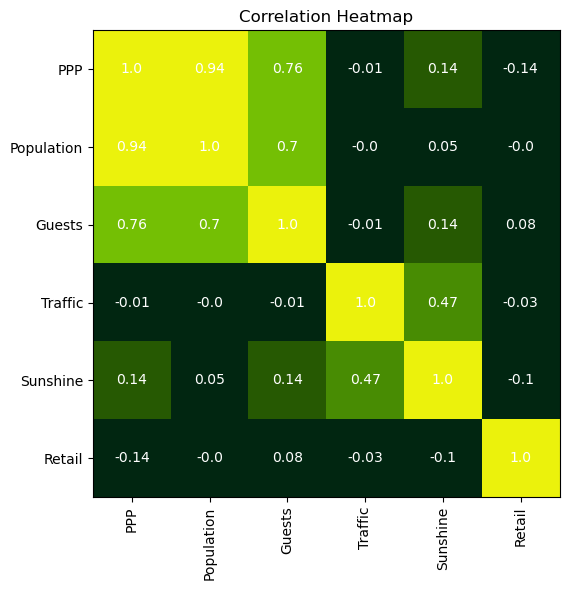

In [5]:
# Show correlation matrix
from matplotlib.colors import ListedColormap

# Define the custom color scheme
custom_colors = ['#012611', '#265902', '#488C03', '#74BF04', '#EBF20C']

# Create a ListedColormap
cmap_custom = ListedColormap(custom_colors)

# Show correlation matrix
correlation_matrix = features.corr().round(2)

# Visualize the correlation in a heatmap and annotate
fig, ax = plt.subplots(figsize=(8, 6))

# Using the custom color scheme
im = ax.imshow(correlation_matrix, cmap=cmap_custom)

# Set x and y axis labels
ax.set_xticks(range(len(correlation_matrix.columns)))
ax.set_yticks(range(len(correlation_matrix.columns)))

# Set x and y axis labels using the column names
ax.set_xticklabels(correlation_matrix.columns, rotation=90)
ax.set_yticklabels(correlation_matrix.columns)

# Loop over data dimensions and create text annotations
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        text = ax.text(j, i, correlation_matrix.iloc[i, j], ha="center", va="center", color="w")

# Set labels and title
ax.set_title('Correlation Heatmap')
fig.tight_layout()
plt.show()
fig.savefig('correlation_heatmap.png')

# Data normalization

In [6]:
# Apply log to the non binary features as all were skewed
features = np.log(features)

# Apply same diff transformation to hourly data as to target
features["Traffic"] = features["Traffic"].diff(24)
features["Sunshine"] = features["Sunshine"].diff(24)
features = features.dropna()

# Merge features
features = pd.merge(features, binary, left_index = True, right_index = True, how = "left")

In [7]:
# Some data is missing as log could not be applied to 0
passengers = passengers.resample("H").sum().fillna(0)

In [8]:
# Split into training and test split
n_splits = 2
tscv = TimeSeriesSplit(n_splits)

y = passengers[["total"]].copy()
X = features.copy()

for train_index, test_index in tscv.split(passengers):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [9]:
# Standardize the Data to obtain better results
# Only standardize non binary data
non_binary = ['PPP', 'Population', 'Guests', 'Traffic', 'Sunshine', 'Retail']
X_train_nb = X_train[non_binary]
X_test_nb = X_test[non_binary]

# Standardize data
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_nb), columns = X_train_nb.columns).set_index(X_train_nb.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_nb), columns = X_test_nb.columns).set_index(X_test_nb.index)

# Concatenate with dummy variables
X_train_scaled = pd.merge(X_train_scaled, X_train[binary.columns], how = "left", left_index = True, right_index = True)
X_test_scaled = pd.merge(X_test_scaled, X_test[binary.columns], how = "left", left_index = True, right_index = True)

# Building the model

Use Lasso to find most important features

In [10]:
from sklearn.linear_model import LassoCV

In [11]:
# Use TimeSeriesSplit for cross-validation
tscv_cv = TimeSeriesSplit(n_splits=3) 

# Apply LassoCV
lasso_cv = LassoCV(alphas=np.logspace(-3, 3, 200), cv=tscv_cv)
lasso_cv.fit(X_train_scaled, y_train.values.ravel())

# Display the selected alpha
print(f"Selected Alpha: {lasso_cv.alpha_: 0.5f}")

# Examine coefficents
coefficients_df = pd.DataFrame({"Coefficient": lasso_cv.coef_}, index = X_train_scaled.columns)
# Show relevant and irrelevant coffecients
zero_coefficents = coefficients_df[coefficients_df["Coefficient"] == 0]
non_zero_coefficents = coefficients_df[coefficients_df["Coefficient"] != 0]
print(f"Lasso dropped {zero_coefficents.shape[0]} coefficients")

Selected Alpha:  0.00401
Lasso dropped 25 coefficients


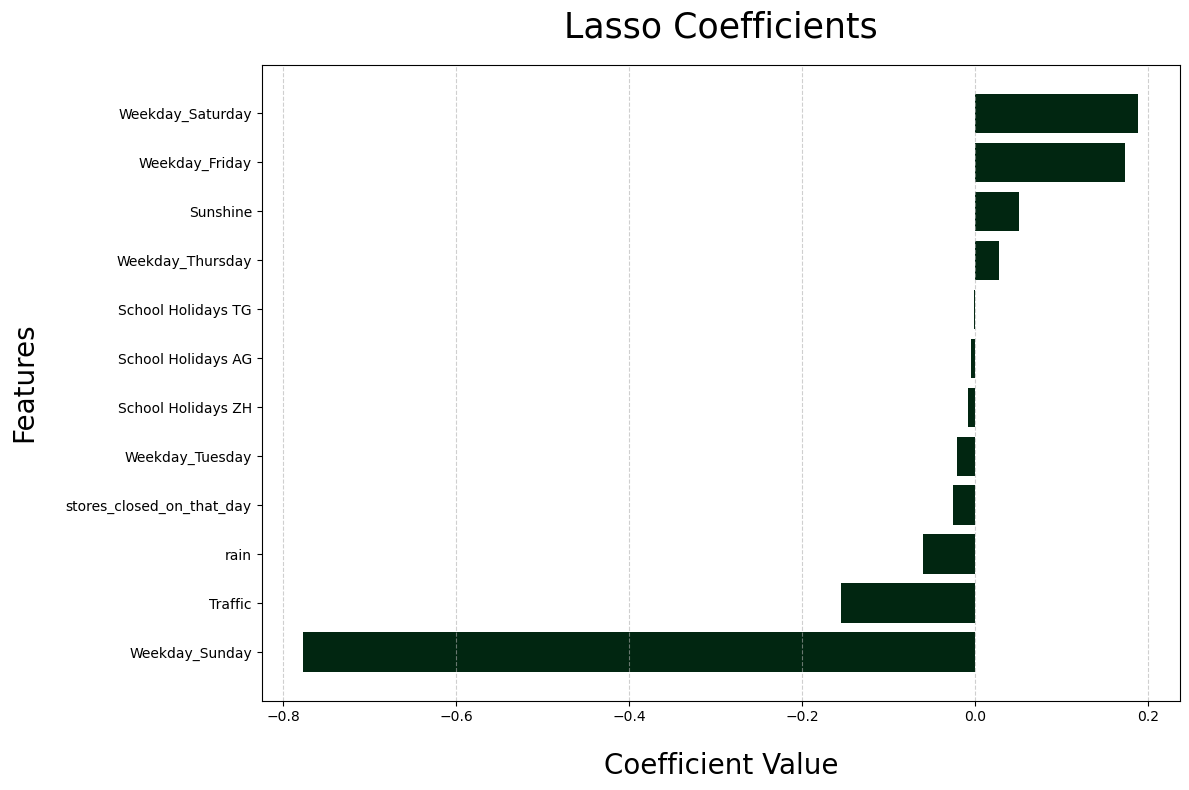

In [12]:
# Plot the Lasso Coefficients
plt.figure(figsize=(12, 8))

plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
# Define the custom color scheme
custom_colors = ['#012611', '#265902', '#488C03', '#74BF04', '#EBF20C']

# Set the custom color palette
sns.set_palette(custom_colors)
non_zero_coefficents = non_zero_coefficents.sort_values(by = "Coefficient")

# Plotting horizontal bar chart
plt.barh(non_zero_coefficents.index, non_zero_coefficents["Coefficient"])


plt.title("Lasso Coefficients", fontsize = 25, pad = 20)
plt.xlabel("Coefficient Value", labelpad = 20, fontsize = 20)
plt.ylabel("Features", labelpad = 20, fontsize = 20)

plt.grid(axis="x", linestyle="--", alpha=0.6);
plt.tight_layout()

plt.savefig("lasso.png");

In [13]:
# Drop the zero coefficents
non_zero_coef = list(non_zero_coefficents.index)
X_train_scaled = X_train_scaled[non_zero_coef].copy()
X_test_scaled = X_test_scaled[non_zero_coef].copy()

## Training the LSTM

In [14]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

2023-12-09 19:36:04.320374: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-09 19:36:04.323992: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-09 19:36:04.359821: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-09 19:36:04.359860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-09 19:36:04.361137: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Optimize model

In [15]:
# Define the validation data
# Set the number of time steps for validation
validation_percentage = 0.2

# Calculate the index to split the data
split_index = int(len(X_train_scaled) * (1 - validation_percentage))

# Split the data
X_train_scaled_split, X_val = X_train_scaled[:split_index], X_train_scaled[split_index:]
y_train_split, y_val = y_train[:split_index], y_train[split_index:]

In [16]:
def build_model(hp):
    
    model = keras.Sequential()
    model.add(LSTM(units=50, input_shape=(X_train_scaled_split.shape[1],1)))
    
    # Tune the number of Dense layers and the number of neurons
    for i in range(hp.Int("num_layers", min_value=1, max_value=5, step=1)):
        
        model.add(Dense(units=hp.Int("units_" + str(i), min_value=32, max_value=256, step=32),
                               activation=hp.Choice("activation_" + str(i), values=["relu", "sigmoid", "tanh", "linear"])))
        
        # Add dropout layer with a tunable rate
        model.add(layers.Dropout(rate=hp.Float("dropout_" + str(i), min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer. Apply linear activation function as scaled passenger target can have positive and negative values
    model.add(layers.Dense(1, activation = "linear")) 

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
                  loss="mse", metrics=["mse"]) 

    return model
    

# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective= "mse",
    max_trials= 7
)


# Perform hyperparameter search
tuner.search(X_train_scaled_split, y_train_split,
             epochs= 10, 
             validation_data=(X_val, y_val))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

Reloading Tuner from ./untitled_project/tuner0.json


In [17]:
early_stopping = EarlyStopping(monitor="val_loss", patience=3)  
# Train the best model with a larger number of epochs
history = best_model.fit(X_train_scaled_split, y_train_split, epochs=100, validation_data=(X_val, y_val),callbacks=[early_stopping])

Epoch 1/100
307/307 [==============================] - 7s 17ms/step - loss: 0.5305 - mse: 0.5305 - val_loss: 0.5019 - val_mse: 0.5019
Epoch 2/100
307/307 [==============================] - 5s 15ms/step - loss: 0.4711 - mse: 0.4711 - val_loss: 0.4925 - val_mse: 0.4925
Epoch 3/100
307/307 [==============================] - 5s 15ms/step - loss: 0.4602 - mse: 0.4602 - val_loss: 0.4827 - val_mse: 0.4827
Epoch 4/100
307/307 [==============================] - 4s 14ms/step - loss: 0.4614 - mse: 0.4614 - val_loss: 0.4777 - val_mse: 0.4777
Epoch 5/100
307/307 [==============================] - 4s 14ms/step - loss: 0.4526 - mse: 0.4526 - val_loss: 0.5014 - val_mse: 0.5014
Epoch 6/100
307/307 [==============================] - 4s 14ms/step - loss: 0.4316 - mse: 0.4316 - val_loss: 0.4908 - val_mse: 0.4908
Epoch 7/100
307/307 [==============================] - 4s 13ms/step - loss: 0.4227 - mse: 0.4227 - val_loss: 0.4713 - val_mse: 0.4713
Epoch 8/100
307/307 [==============================] - 4s 13ms

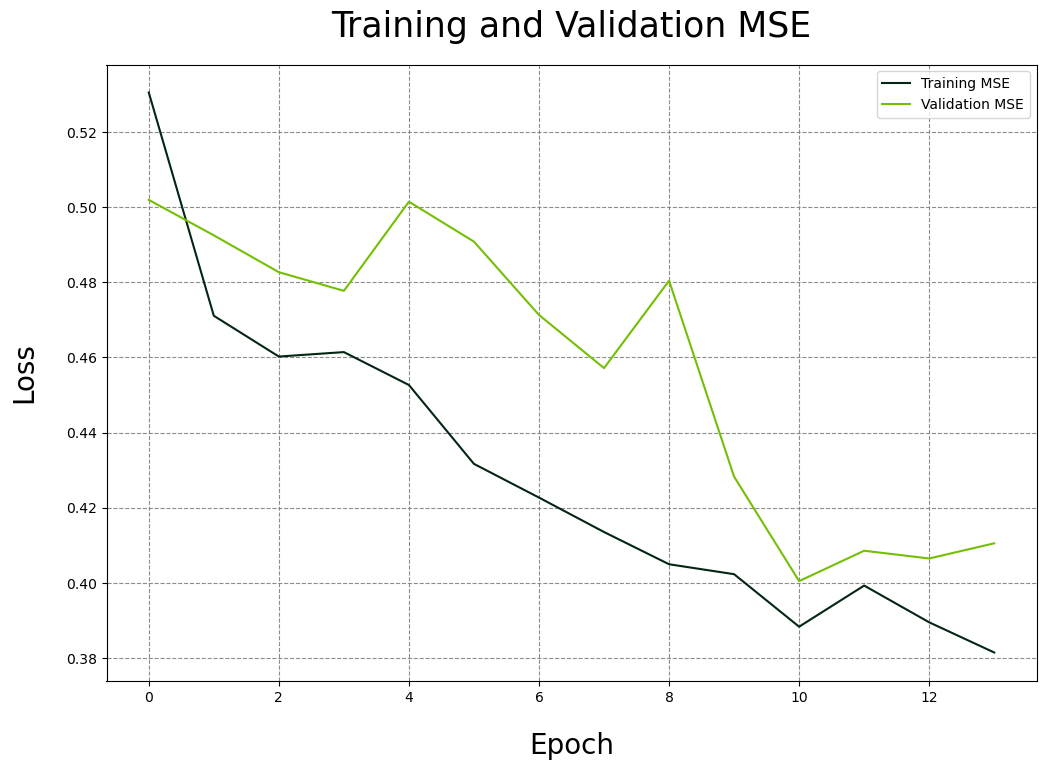

In [18]:
custom_colors = ['#012611','#74BF04', '#EBF20C']


# Set the custom color palette
sns.set_palette(custom_colors)

# Plot training and validation loss
fig, ax = plt.subplots(figsize = (12,8))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
ax.plot(history.history['mse'], label='Training MSE')
ax.plot(history.history['val_mse'], label='Validation MSE')
ax.set_title('Training and Validation MSE',  pad = 20, fontsize = 25)
ax.set_xlabel('Epoch',  labelpad = 20, fontsize = 20)
ax.set_ylabel('Loss',labelpad = 20, fontsize = 20)
ax.grid(color="grey", linestyle = "dashed", alpha = 0.9)
ax.legend()

# Save the plot
plt.savefig("lstm_loss.png")

# Show the plot
plt.show()

## Making predictions

### Necessary functions

In [19]:
# Generate predictions (not yet converted back to normal data)
def generate_prediction(X):
    # Change to best model
    predicted_scaled = pd.DataFrame(best_model.predict(X), index = X.index)
    predicted_scaled.columns = ["Prediction"]
    return predicted_scaled

In [20]:
# invert differenced value
def inverse_difference(yhat, history = passengers_df, interval=24):
    # Merge the logged actual data and the prediction
    x = pd.merge(history[["log"]], yhat, left_index = True, right_index = True)
    
    # Shift by the number of periods used to remove the seasonality
    x["Shifted"] = x.log.shift(interval)
    # Drop the 24 days for which no previous season available
    x = x.dropna()
    # Show to actual prediction by summing the prediction and the past seasonal value and reversing the log transformation
    x["pred"] = np.exp(x.Prediction+x.Shifted)
    # Show the actual data by reversing the log transformation
    x["actual"] = np.exp(x.log)
    return x

In [21]:
def mse(y_hat, y):
    return np.mean((y_hat - y)**2)

### Making predictions

In [22]:
# Showing predictions of test data
predicted_scaled = generate_prediction(X_test_scaled)
pred = inverse_difference(predicted_scaled)

192/192 [==============================] - 1s 5ms/step


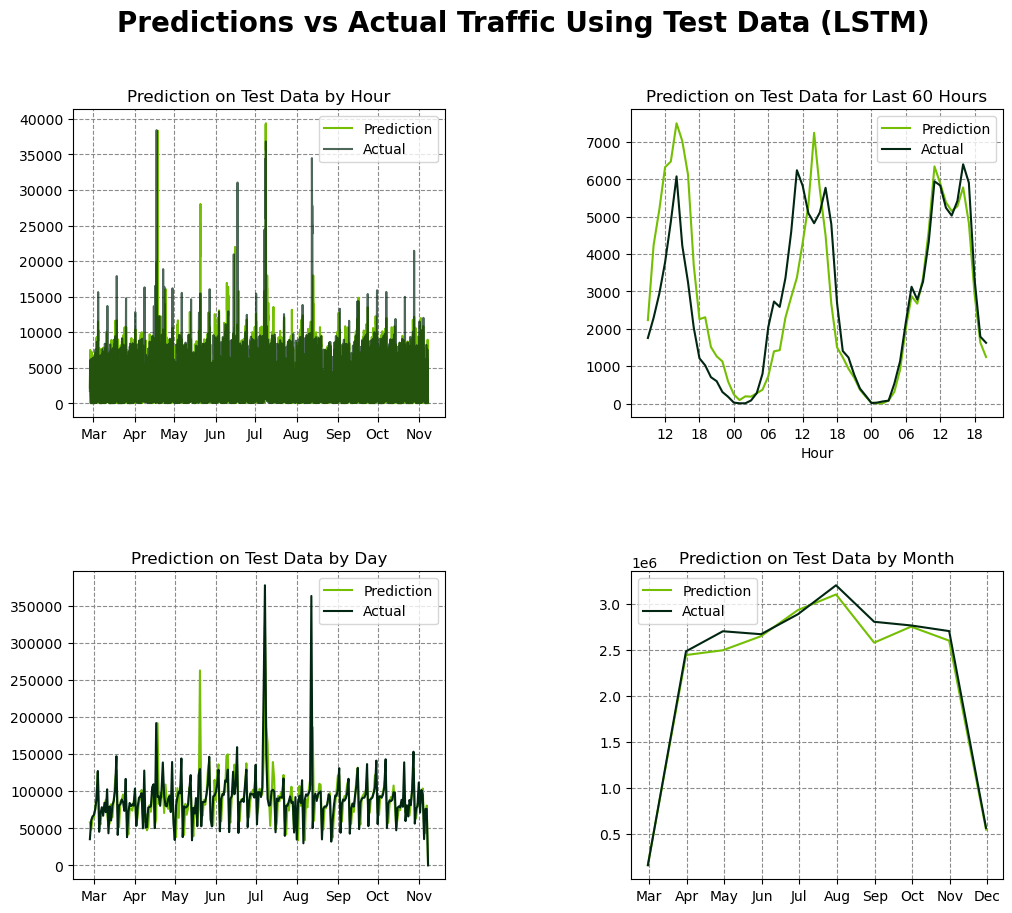

In [25]:
from matplotlib.dates import DateFormatter
# Plotting predictions
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Predictions vs Actual Traffic Using Test Data (LSTM)", fontweight="bold", fontsize = 20)
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

# Custom colors
prediction_color = '#74BF04'
actual_color = '#012611'

# Total predictions
axs[0, 0].plot(pred.pred, c=prediction_color, label="Prediction")
axs[0, 0].grid(color="grey", linestyle = "dashed", alpha = 0.9)
axs[0, 0].plot(pred.actual, c=actual_color, label="Actual", alpha=0.7)
axs[0, 0].set_title("Prediction on Test Data by Hour", )
axs[0, 0].legend()

# Last 60 hours to see whether daily seasonality captured
axs[0, 1].plot(pred.pred.head(60), c=prediction_color, label="Prediction")
axs[0, 1].plot(pred.actual.head(60), c=actual_color, label="Actual")
axs[0, 1].set_title("Prediction on Test Data for Last 60 Hours",)
axs[0, 1].set_xlabel("Hour")
axs[0, 1].grid(color="grey", linestyle = "dashed", alpha = 0.9)
axs[0, 1].legend()

# By day
axs[1, 0].plot(pred.resample("D").sum().pred, c=prediction_color, label="Prediction")
axs[1, 0].plot(pred.resample("D").sum().actual, c=actual_color, label="Actual")
axs[1, 0].set_title("Prediction on Test Data by Day", )
axs[1, 0].grid(color="grey", linestyle = "dashed", alpha = 0.9)
axs[1, 0].legend()

# By month
axs[1, 1].plot(pred.resample("M").sum().pred, c=prediction_color, label="Prediction")
axs[1, 1].plot(pred.resample("M").sum().actual, c=actual_color, label="Actual")
axs[1, 1].set_title("Prediction on Test Data by Month")
axs[1, 1].grid(color="grey", linestyle = "dashed", alpha = 0.9)
axs[1, 1].legend()
# Format x-Axis
date_form_hour = DateFormatter("%b")
date_form_60 = DateFormatter("%H")
axs[0, 0].xaxis.set_major_formatter(date_form_hour)
axs[0, 1].xaxis.set_major_formatter(date_form_60)
axs[1, 1].xaxis.set_major_formatter(date_form_hour)
axs[1, 0].xaxis.set_major_formatter(date_form_hour)

plt.savefig("lstm.png")

In [24]:
mse_nn = mse(pred.pred, pred.actual)
print(f"The MSE of the LSTM is{mse_nn: 0.3f}")

The MSE of the LSTM is 5385744.815
